In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import pandas as pd
import networkx as nx
import scipy as sp
import scipy.stats

#see https://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/

In [38]:
class StructGraph: #class to describe graphs with sub-strcutres, e.g. lines.
    def __init__(self, full_graph, structure):
        self.full = full_graph
        self.structure = structure
        self.big_struc = nx.Graph() #make the strcuture graph include all nodes from the full graph
        self.big_struc.add_nodes_from(full_graph)
        self.big_struc.add_edges_from(structure.edges)
        
        self.stoc_mat = None
        self.adj_mat = None
        
        self.struc_sink = None

    def get_adj_mat(self):
#         if self.adj_mat == None:
#             self.adj_mat = nx.convert_matrix.to_numpy_matrix(self.full)
        self.adj_mat = nx.convert_matrix.to_numpy_matrix(self.full)
        return self.adj_mat
        
    def get_stoc_mat(self):
#         if self.stoc_mat == None:
#             adj_mat = self.get_adj_mat()
#             self.stoc_mat = adj_mat/np.sum(adj_mat, axis=0)
        adj_mat = self.get_adj_mat()
        self.stoc_mat = adj_mat/np.sum(adj_mat, axis=0)
        return self.stoc_mat
        
    def get_struc_sink(self):
#         if self.struc_sink == None:
#             struc_adj_mat = nx.convert_matrix.to_numpy_matrix(self.big_struc)
#             row = np.sum(struc_adj_mat, axis=1)
#             self.struc_sink = np.logical_not((row.astype(bool))).astype(int)

        struc_adj_mat = nx.convert_matrix.to_numpy_matrix(self.big_struc)
        row = np.sum(struc_adj_mat, axis=1)
        self.struc_sink = np.logical_not((row.astype(bool))).astype(int)
        return self.struc_sink
    
    def return_times(self, initial, max_iter=100):
        step_mat = self.get_stoc_mat()
        sink = self.get_struc_sink()
        
        state = initial
        
        remaining_p = []
        remaining_p.append(np.sum(state))

        for _ in range(max_iter):
            state = np.dot(step_mat, state)
            state = np.multiply(sink, state)
            remaining_p.append(np.sum(state))
            
        return np.array(remaining_p)

In [39]:
cols = {'Bakerloo Line':'AE6017',
'Circle Line':'FFE02B',
'Hammersmith & City Line':'F491A8',
'Jubilee Line':'949699',
'Victoria Line':'0A9CDA',
'Central Line':'F15B2E',
'District Line':'00A166',
'East London Line':'FBAE34',
'Metropolitan Line':'91005A',
'Northern Line':'000000',
'Piccadilly Line':'094FA3',
'Waterloo & City Line':'88D0C4',
'Docklands Light Railway':'00A77E'}

In [40]:
loc = 'datasets'

lines       = pd.read_csv('{}/london.lines.csv'.format(loc), index_col=0)
stations    = pd.read_csv('{}/london.stations.csv'.format(loc), index_col=0)
connections = pd.read_csv('{}/london.connections.csv'.format(loc))

In [41]:
#make a simple graph for each line

line_graphs = {}

for line_no in lines.index.values:
    
    current_line = connections.loc[connections['line'] == line_no]

    line_graphs[lines.loc[line_no]['name']] = nx.Graph()

    for connection_id, connection in current_line.iterrows():
        station1_name = stations.ix[connection['station1']]['name']
        station2_name = stations.ix[connection['station2']]['name']
        line_graphs[lines.loc[line_no]['name']].add_edge(station1_name, station2_name, time = connection['time'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [46]:
#add all the lines to make the full network multi-graph
working_line = 'Bakerloo Line'
full_map = nx.MultiGraph()

for current_line in line_graphs.values():
    full_map.add_edges_from(current_line.edges)
    
# full_graph = full_map
# structure = line_graphs[working_line]

In [47]:
#find the return times to the line, using intial populations andd transfer matrices - modified to remove walkers
# i.e. set the components of the transfer matrix on the line to zero and they will act as sink, measure the proportion lost each interation.

#find the diffusion from the lines, using transfer matrix, initial population

full_test = StructGraph(full_map, line_graphs[working_line])
initial = np.sum(nx.convert_matrix.to_numpy_matrix(full_test.big_struc), axis=1)
initial_norm = initial/np.sum(initial)
returns = full_test.return_times(initial_norm)

[]

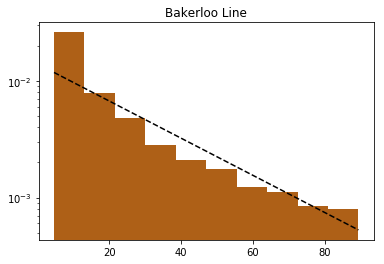

In [51]:
# def plot_return_times(returns, col='k', line_name=None, start_pos=0, line='True')
# plt.hist(range(len(returns[skip_first:])), weights=returns[skip_first:])

diffreturns = returns[:-1]-returns[1:]

start_pos=5

fig = plt.figure()

# x, ws = range(len(returns[:])), (returns[:])

ws, edges = np.histogram(range(len(diffreturns[start_pos:])), bins=10, range=None, normed=None, weights=diffreturns[start_pos:], density=None)

x, bins = (edges[:-1] + edges[1:])/2, len(edges)-1

slope, intercept, _, _, std_err = sp.stats.linregress(x, np.log(ws))
plt.hist(x, weights=ws, density=False, bins=bins, color='#{}'.format(cols["Bakerloo Line"]))
plt.plot(x, np.exp(x*slope+intercept), 'k--')
plt.title(label=working_line)
plt.semilogy()

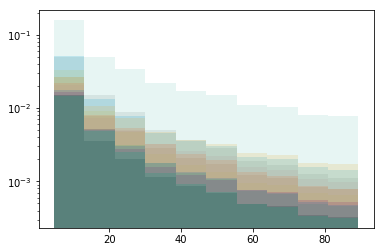

In [62]:
for working_line in line_graphs.keys():
    #find the return times to the line, using intial populations andd transfer matrices - modified to remove walkers
    # i.e. set the components of the transfer matrix on the line to zero and they will act as sink, measure the proportion lost each interation.

    #find the diffusion from the lines, using transfer matrix, initial population

    full_test = StructGraph(full_map, line_graphs[working_line])
    initial = np.sum(nx.convert_matrix.to_numpy_matrix(full_test.big_struc), axis=1)
    initial_norm = initial/np.sum(initial)
    returns = full_test.return_times(initial_norm)

    # def plot_return_times(returns, col='k', line_name=None, start_pos=0, line='True')
    # plt.hist(range(len(returns[skip_first:])), weights=returns[skip_first:])

    diffreturns = returns[:-1]-returns[1:]

    start_pos=5

#     fig = plt.figure()

    # x, ws = range(len(returns[:])), (returns[:])

    ws, edges = np.histogram(range(len(diffreturns[start_pos:])), bins=10, range=None, normed=None, weights=diffreturns[start_pos:], density=None)

    x, bins = (edges[:-1] + edges[1:])/2, len(edges)-1

    slope, intercept, _, _, std_err = sp.stats.linregress(x, np.log(ws))

    plt.hist(x, weights=ws, density=False, bins=bins, color='#{}'.format(cols[working_line]), alpha=0.2)
#     plt.plot(x, np.exp(x*slope+intercept), 'k--')
#     plt.title(label=working_line)
    plt.semilogy()

In [69]:
ta_mat = nx.convert_matrix.to_numpy_matrix(full_test.full)

In [118]:
fake_adj = []

for i in range
i*np.linalg.matrix_power(ta_mat, i).astype(bool).astype(int)

matrix([[2, 0, 0, ..., 0, 0, 0],
        [0, 2, 2, ..., 0, 0, 0],
        [0, 2, 2, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 2, 0, 2],
        [0, 0, 0, ..., 0, 2, 0],
        [0, 0, 0, ..., 2, 0, 2]])

In [109]:
ta_mat[0]
filtered_list = [i for (i, v) in zip(list(full_test.full.nodes()), ta_mat[:,0]) if v != 0]
filtered_list

['Marylebone',
 "Regent's Park",
 'Edgware Road (C)',
 'Great Portland Street',
 'Bond Street',
 "St. John's Wood",
 'Finchley Road']

In [113]:
ta_mat.astype(bool).astype(int)

matrix([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 1, 0]])

In [122]:
ta_mat[:,0]

matrix([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
      

In [143]:
class StructGraph: #class to describe graphs with sub-strcutres, e.g. lines.
    def __init__(self, full_graph, structure):
        self.full = full_graph
        self.structure = structure
        self.big_struc = nx.Graph() #make the strcuture graph include all nodes from the full graph
        self.big_struc.add_nodes_from(full_graph)
        self.big_struc.add_edges_from(structure.edges)

    def get_adj_mat(self):
#         if self.adj_mat == None:
#             self.adj_mat = nx.convert_matrix.to_numpy_matrix(self.full)
        self.adj_mat = nx.convert_matrix.to_numpy_matrix(self.full)
        return self.adj_mat
        
    def get_stoc_mat(self):
#         if self.stoc_mat == None:
#             adj_mat = self.get_adj_mat()
#             self.stoc_mat = adj_mat/np.sum(adj_mat, axis=0)
        adj_mat = self.get_adj_mat()
        self.stoc_mat = adj_mat/np.sum(adj_mat, axis=0)
        return self.stoc_mat
        
    def get_struc_sink(self):
#         if self.struc_sink == None:
#             struc_adj_mat = nx.convert_matrix.to_numpy_matrix(self.big_struc)
#             row = np.sum(struc_adj_mat, axis=1)
#             self.struc_sink = np.logical_not((row.astype(bool))).astype(int)

        struc_adj_mat = nx.convert_matrix.to_numpy_matrix(self.big_struc)
        row = np.sum(struc_adj_mat, axis=1)
        self.struc_sink = np.logical_not((row.astype(bool))).astype(int)
        return self.struc_sink
    
    def return_times(self, initial, max_iter=100):
        step_mat = self.get_stoc_mat()
        sink = self.get_struc_sink()
        
        state = initial
        
        remaining_p = []
        remaining_p.append(np.sum(state))

        for _ in range(max_iter):
            state = np.dot(step_mat, state)
            state = np.multiply(sink, state)
            remaining_p.append(np.sum(state))
            
        return np.array(remaining_p)
    
dist_vector = np.zeros(full_test.get_struc_sink().shape)
struc_sink = self.get_struc_sink()
non_struc = np.sum(struc_sink)
i=0
current_pos=

while(np.sum((dist_vector.astype(bool))*struc_sink) < non_struc and i < struc_sink.shape[0]):
    dsa
    



nx.adjacency_matrix()
np.sum(nx.convert_matrix.to_numpy_matrix(full_test.big_struc), axis=1)


SyntaxError: invalid syntax (<ipython-input-143-8401576193f6>, line 51)

In [153]:
bool(0.1)

True

In [130]:
np.zeros(full_test.get_struc_sink()

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [139]:
np.array([[0.5], [0], [1], [2]]).any() == 0.5

False

In [137]:
0.5*np.ones(full_test.get_struc_sink().shape).any() == 0.5

True

In [ ]:
init_dists = 0.5*np.ones(full_test.get_struc_sink().shape)
init_dists

dists